# The impact of topology on epidemic spreading

In [31]:
# maths support
import numpy

# data handling
import pandas
from pathlib import Path
datasets = Path("../../datasets")
datasets.mkdir(parents=True, exist_ok=True)

# simulation
from epyc import Experiment, ParallelLab, JSONLabNotebook
from epydemic import ERNetwork, BANetwork, PLCNetwork, FixedNetwork, SIR, StochasticDynamics

# plotting
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['font.size'] = 10
import matplotlib.pyplot as plt

In [25]:
# create a lab notebook backed by a JSON file
# (note that the notebook will be loaded, not overwritten, if it exists already)
nb = JSONLabNotebook(Path(datasets, "09-10-sir-topology.json"))

In [26]:
from multiprocessing import cpu_count
print("Current system has {c} cores in total".format(c=cpu_count()))

# pick the number of cores -- change this to change parallelism
nCores = -2

# create the lab
lab = ParallelLab(notebook=nb, cores=nCores)

Current system has 16 cores in total


In [40]:
def make_plc(N, exponent, cutoff, pInfects, reps = 10):
    '''Return a function to do SIR on a PLC network, where the
    network is re-used.
    
    :param N: the size of the network
    :param exponent: the exponent of the degree distribition
    :param cutoff: the cut-off
    :param pInfects: the range of pInfect values
    :param reps: (optional) the number of repetitions (defaults to 10)
    :returns: an experiment function'''
    
    def sir_plc(lab):
        '''Simulate epidemics across the pInfect space on a PLC network.'''

        # set the disease parameter space
        lab[SIR.P_INFECTED] = 0.001
        lab[SIR.P_INFECT] = pInfects
        lab[SIR.P_REMOVE] = 0.002
        lab['repetitions'] = range(reps)
    
        # since they're expensive to construct, we'll build
        # one network with PLC topology and re-seed it for
        # each experiment
        params = dict()
        params[PLCNetwork.N] = N
        params[PLCNetwork.EXPONENT] = exponent
        params[PLCNetwork.CUTOFF] = cutoff
        g = PLCNetwork().set(params).generate()

        # create the model, network, and experiment
        m = SIR()
        e = StochasticDynamics(m, g)
    
        # run the experiment
        lab.runExperiment(e)
        
    return sir_plc

In [44]:
N = int(1e4)
exponent = 2
cutoff = 10

In [37]:
lab.createWith("sir_plc",
               make_plc(N, exponent, cutoff, numpy.linspace(0.0, 1.0, num=100)),
               "SIR epidemic on PLC network")

True

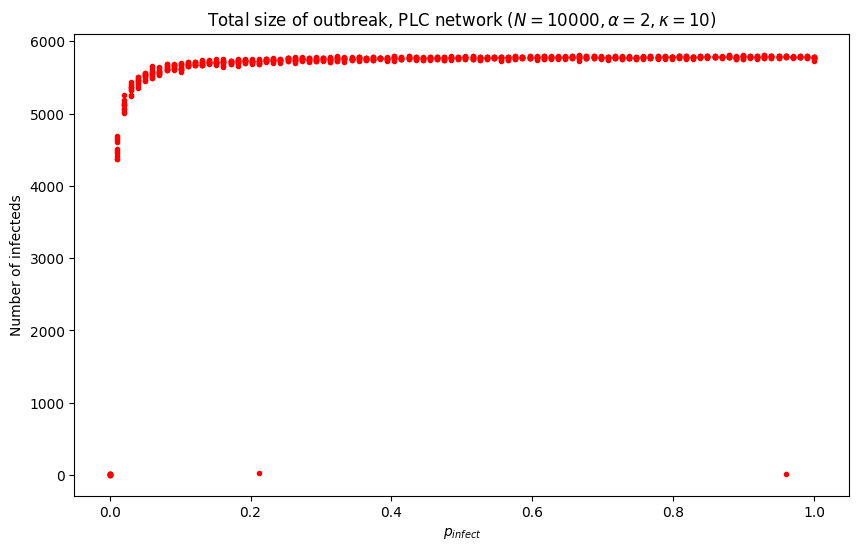

In [47]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca()

# plot the sizes of final outbreak size (the R compartment) for different values of pInfect
df = nb.dataframe("sir_plc")
ax.plot(df[SIR.P_INFECT], df[SIR.REMOVED], 'r.')

# fill in the title and axis labels
ax.set_title(f'Total size of outbreak, PLC network ($N = {N}, \\alpha={exponent}, \\kappa={cutoff}$)')
ax.set_xlabel('$p_{infect}$')
ax.set_ylabel('Number of infecteds')
plt.show()

In [41]:
lab.createWith("sir_plc_lowinfectivity",
               make_plc(int(1e4), 2, 10, numpy.linspace(0.0, 0.01, num=250)),
               "SIR epidemic on PLC network (low infectivity)")

True

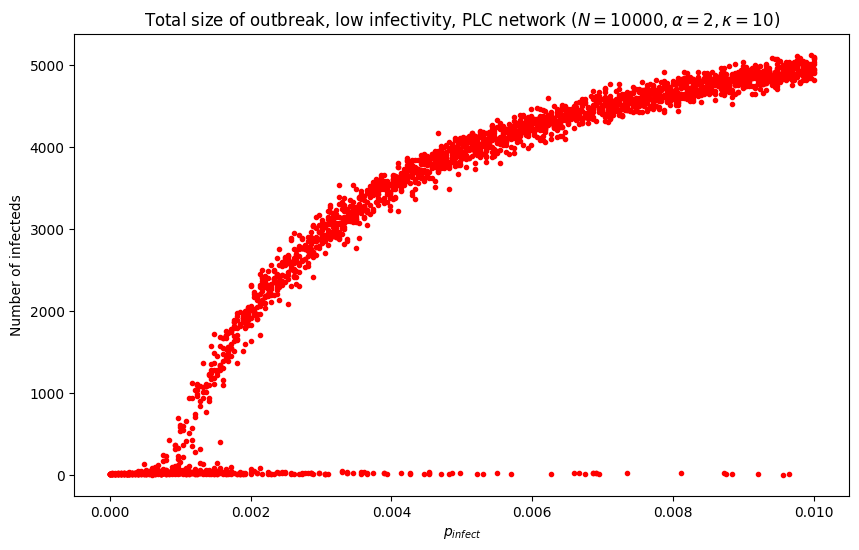

In [49]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca()

# plot the sizes of final outbreak size (the R compartment) for different values of pInfect
df = nb.dataframe("sir_plc_lowinfectivity")
ax.plot(df[SIR.P_INFECT], df[SIR.REMOVED], 'r.')

# fill in the title and axis labels
ax.set_title(f'Total size of outbreak, low infectivity, PLC network ($N = {N}, \\alpha={exponent}, \\kappa={cutoff}$)')
ax.set_xlabel('$p_{infect}$')
ax.set_ylabel('Number of infecteds')
plt.show()

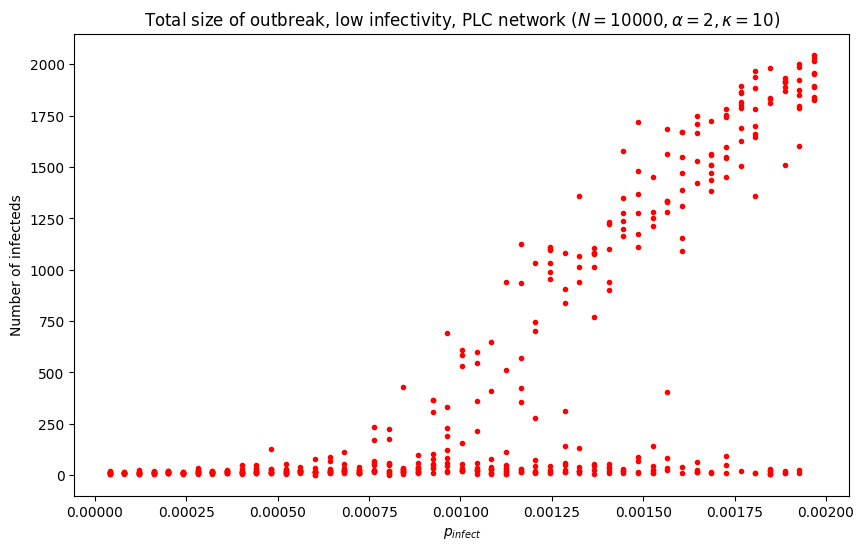

In [50]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca()

# plot the sizes of final outbreak size (the R compartment) for different values of pInfect
df = nb.dataframe("sir_plc_lowinfectivity")
df1 = df[df[SIR.P_INFECT] > 0.00003]
df2 = df1[df1[SIR.P_INFECT] < 0.002]
ax.plot(df2[SIR.P_INFECT], df2[SIR.REMOVED], 'r.')

# fill in the title and axis labels
ax.set_title(f'Total size of outbreak, low infectivity, PLC network ($N = {N}, \\alpha={exponent}, \\kappa={cutoff}$)')
ax.set_xlabel('$p_{infect}$')
ax.set_ylabel('Number of infecteds')
plt.show()